# Principle Component Analysis

In this notebook, we will show some examples of [Principle Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and its modern variations.

## Outline
- Introduction to PCA ([slides](https://github.com/tingsyo/course_2020Q3_representation_learning/blob/master/notebooks/02_PCA_andits_variations.pptx))
- PCA with the MNIST dataset
- PCA with NOAA-GridSat-B1


## Introduction to PCA ([slides](https://github.com/tingsyo/course_2020Q3_representation_learning/blob/master/notebooks/02_PCA_andits_variations.pptx))

## PCA with the MNIST dataset

### MNIST
- MNIST 是一個手寫數字的圖像資料集，經常用於圖像辨識的基本範例。
- MNIST 資料集可至 [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)下載。
- 完整版的 MNIST 資料集包含 60000 個訓練圖片和 10000 個測試圖片，每個圖片大小是 28 * 28 像素。
- Python 的 scikit-learn 套件內建了簡易版的 [MNIST dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

|MNIST in sklearn|-|
|-----------|------------|
|Classes	|10|
|Samples per class	|~180|
|Samples total	|1797|
|Dimensionality	|64|
|Features	|integers 0-16|


首先，我們來讀取 scikit-learn 內建的 MNIST dataset，依據[使用手冊](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)的說明，會提供一個 1797\*64 和一個 1797\*1 的 numpy.Array，前者是 1797 張 8\*8 的影像，而後者是每一張影像所寫的「數字」。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import datasets

# The digits dataset
digits = datasets.load_digits()
print(digits.data.shape)
print(digits.target.shape)
print(pd.crosstab(digits.target,'count'))

(1797, 64)
(1797,)
col_0  count
row_0       
0        178
1        182
2        177
3        183
4        181
5        182
6        181
7        179
8        174
9        180


接著，我們來看看資料集裡圖片的長相：

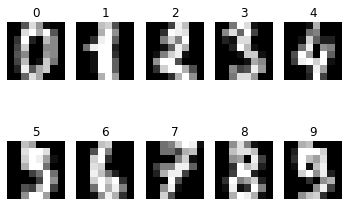

In [2]:
# Create a 2*5 plots for each digit
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, squeeze=False)

# Loop through each class
for i in range(10):
    # Retrieve the first image of the given digit
    img = digits.data[(digits.target==i)][0]
    x = i // 5    # Put the digit to the right row/col
    y = i % 5
    axes[x,y].imshow(img.reshape(8,8), cmap='gray')
    axes[x,y].axis('off')
    axes[x,y].set_title(str(i))

所以，我們的 digits.data 資料集，是把每張 8\*8 像素的影像扁平化（[`numpy.flatten()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.flatten.html)），成為長度為 64 的向量，我們可以把每個像素想像成一個變項 $X_i$，如果我們對這個 1797\*64 的矩陣做 PCA，我們計算出的結果代表著什麼實際意義？

讓我們先看看各主成分的解釋變異量：

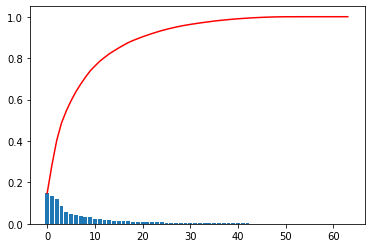

In [3]:
pca_mnist = PCA(n_components=64, svd_solver='full')
pca_mnist.fit(digits.data)
# np.cumsum(X) will calculate the cumulative sum of X
plt.bar(range(64),pca_mnist.explained_variance_ratio_)
plt.plot(np.cumsum(pca_mnist.explained_variance_ratio_), 'r-')
plt.show()

我們可以很明顯的看到，與前面的幾個例子比較，手寫數字的影像資料，並不容易用少數的幾個主成分就解釋大部分的變異，至少要 13 個的主成分，才能解釋 80% 的變異量；要解釋90%的變異量則需要21個主成分。

In [4]:
print(np.cumsum(pca_mnist.explained_variance_ratio_))

[0.14890594 0.28509365 0.40303959 0.48713938 0.54496353 0.59413263
 0.6372925  0.67390623 0.70743871 0.73822677 0.76195018 0.78467714
 0.80289578 0.82063433 0.83530534 0.84940249 0.86258838 0.87506976
 0.88524694 0.89430312 0.9031985  0.91116973 0.91884467 0.9260737
 0.93303259 0.9389934  0.94474955 0.94990113 0.95479652 0.9590854
 0.96282146 0.96635421 0.96972105 0.97300135 0.97608455 0.97902234
 0.98158823 0.98386565 0.98608843 0.98820273 0.99010182 0.99168835
 0.99319995 0.99460574 0.99577196 0.99684689 0.99781094 0.99858557
 0.99914278 0.99954711 0.99975703 0.99983951 0.99989203 0.99994255
 0.99997555 0.99998798 0.99999503 0.99999804 0.99999911 0.99999966
 1.         1.         1.         1.        ]


由於手寫數字的影像很容易透過視覺化來理解，恰好可以用來呈現「解釋 N% 的變異量」這件事情是什麼意思。在這裡我們需要用到一些數學，讓我們稍作解釋。

在 PCA 的介紹中提到，我們有一組觀測資料 $X_{M x N}$，包含了對 $N$ 個變數的 $M$ 次觀測，經過 PCA 之後我們找到一組 complete linear transform $W_{N x N}$，使得新座標軸 $Y = X \cdot W $，在 $Y$ 上資料的變異量由大至小排列。在 `sklearn.decomposition.PCA` 裡，$W$ 就是 `PCA.components_`，而原本資料在新座標軸的投影：

PCA.transform(X) = (X - PCA.mean_) $\cdot$ PCA.components_

然而，如果我們只保留前 $K$ 個主成分的資訊（$K < N$），那麼這個線性轉換就不是 complete transform，而重新將新座標軸的資料投影回原座標軸，就達到了「濾波」的效果。要用 scikit-learn 做到這件事情，基本上有兩種作法：

1. 在初始化 PCA 物件的時候，先指定 $K$ 或是「解釋變異量」：

```
pca = PCA(n_components=k)                        # or pca = PCA(0.90)
pca.fit(data)                                    # Calculate the transformation matrix
new_data = pca.transform(data)                   # Project the original data into the new coordinate
filtered_data = pca.inverse_transform(new_data)  # , and then project back
```

2. 計算完整的 PCA，取前 $K$ 個主成分，然後做矩陣運算：

```
pca = PCA()
pca.fit(data)                                                      # Calculate the transformation matrix
new_data = np.dot(data - pca.mean_, pca.components_[:k].T)         # Project the original data into the new coordinate
filtered_data = np.dot(new_data, pca.components_[:k]) + pca.mean_  # , and then project back
```


第一種方法比較簡單，但是當想要嘗試不同 $K$ 的效果時，每次更改 $K$ 就需要重新計算一次，在資料量大的時候效率會比較差。

接下來，我們拿數字 4 和 8 來做例子：

In [6]:
# The original image of 4 and 8
img4 = digits.data[(digits.target==4)][0]
img8 = digits.data[(digits.target==8)][0]

# Fit the PCA
pca = PCA(n_components=64, svd_solver='full')
pca.fit(digits.data)

# Define a function of filter for repeated use
def filter_pca(x, pca, k):
    '''
    x  : numpy array, the original data with shape(N,1).
    pca: object, the fitted PCA with n_components = N.
    k  : integer, the number of PCs to use.
    '''
    x_new = pca.transform(x)
    x_filtered = np.dot(x_new[:,:k], pca.components_[:k]) + pca.mean_
    return(x_filtered)

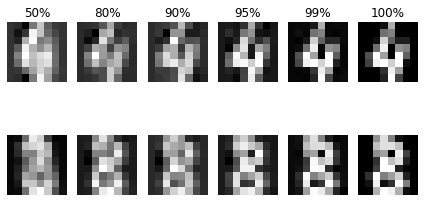

In [7]:
# As shown in above, k required to explain 80%, 90%, 95%, and 99% variance are:
ks = [5, 13, 21, 29, 41, 64]
ps = ['50%', '80%', '90%', '95%', '99%', '100%']

# Create a 2*5 plots for each digit
fig, axes = plt.subplots(2, 6, squeeze=False)

# Loop through each class
for i in range(len(ks)):
    # Calculate filtered images
    img4f = filter_pca(img4.reshape(1,64), pca, ks[i])
    img8f = filter_pca(img8.reshape(1,64), pca, ks[i])
    # Plot
    axes[0,i].imshow(img4f.reshape(8,8), cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(ps[i])
    axes[1,i].imshow(img8f.reshape(8,8), cmap='gray')
    axes[1,i].axis('off')
    
plt.tight_layout()
plt.show()

## PCs of Hand-Written Digits

從上面的例子，我們看到透過使用不同數目的主成分可以達到 filter 的效果，那麼這些主成分又是些什麼？

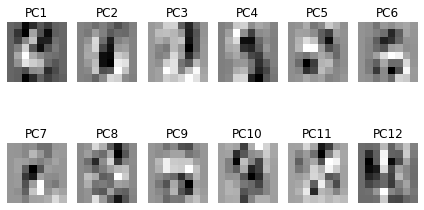

In [8]:
# Create a 2*5 plots for each digit
fig, axes = plt.subplots(2, 6, sharex=True, sharey=True, squeeze=False)

# Loop through each class
for i in range(12):
    # Retrieve the first image of the given digit
    pc = pca.components_[i,:]
    x = i // 6    # Put the digit to the right row/col
    y = i % 6
    axes[x,y].imshow(pc.reshape(8,8), cmap='gray')
    axes[x,y].axis('off')
    axes[x,y].set_title('PC'+str(i+1))
plt.tight_layout()
plt.show()

很顯然，手寫數字影像的主成分，看起來不像是任何單一的數字，但是我們可以理解成 0～9 的數字在 8\*8 像素平面上的「特徵」（feature），而前13個特徵幾乎就可以組合出可以便是的數字了。

如果我們把「手寫數字的影像」換成再分析資料的某個特性層，例如 850hPa 的溫度場，那麼 PCA 結果的詮釋方法，就與這個例子非常類似。事實上，這個方法在地球物理領域叫做 [Emperical Orthogonal Functions (EOF) Analysis](https://en.wikipedia.org/wiki/Empirical_orthogonal_functions) ，早期很多大氣的低頻震盪都是透過這個工具找到的。



## PCA with NOAA-GridSat-B1

上一個例子裡用的 MNIST 資料集，資料維度其實非常小（8\*8\*1797），目前一般的電腦都可以完整處理 SVD solving 的計算，所以我們接下來介紹另一個比較大的資料集，以及如何使用 [Incremental PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)。


### Background information of NOAA-GridSat-B1

According to the [official NOAA website](https://www.ncdc.noaa.gov/gridsat/), the GridSat-B1 CDR data is a *climate quality, long term dataset of global infrared window brightness temperatures*. It has the following characteristics:

- 1981-present (updated quarterly)
- Global coverage (70N to 70S) with 0.07degree interval
- Three channels (IR, WV, VIS)
- Climate quality calibration for IR channel
- Satellites: data included from most meteorological geostationary satellites.

The original data is ~2TB, and it is hard to find a server with memory size greater than $2TB^3$. Hence, we have to use the incremental version of PCA.

In the following example, we will focus on East Asia (0'~60'N, 100'~160'E).


### Handling big dataset with Incremental-PCA

以下程式碼在 [`../utils/ipca_noaagridsatb1.py`](https://github.com/tingsyo/course_2020Q3_representation_learning/blob/master/utils/ipca_noaagridsatb1.py)：

```
# !/usr/bin/env python
# -*- coding: utf-8 -*-
'''
This script provide functions that read and perform PCA with NOAA-GridSat-B1 dataset.
The domain of the raw data ranged from -70' to 69.93'N, -180' to 179.94'E, with 0.07' intervals. 
The data dimension is (1, 2000, 5143), and missing values is -31999.

According to the official how to, the variable(irwin_cdr) contains int16 with values:
    Value = Integer * scale_factor + add_offset
, where scale_factor = 0.01 and offset = 200 (Earth Engine Data Catalog ).

To focus our analysis to East Asia, we cut off a square of 0'~60'N, 100'~160'E (858,858).

The PCA is performed with IncrementalPCA from sklearn.
'''
import numpy as np
import pandas as pd
import os, argparse, logging
from sklearn.decomposition import PCA, IncrementalPCA
import joblib, csv

__author__ = "Ting-Shuo Yo"
__copyright__ = "Copyright 2019~2020, DataQualia Lab Co. Ltd."
__credits__ = ["Ting-Shuo Yo"]
__license__ = "Apache License 2.0"
__version__ = "0.1.0"
__maintainer__ = "Ting-Shuo Yo"
__email__ = "tingyo@dataqualia.com"
__status__ = "development"
__date__ = '2020-07-20'


# Utility functions
def list_noaagridsatb1_files(dir, suffix='.v02r01.nc', to_remove=['GRIDSAT-B1.','.v02r01.nc']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_noaagridsatb1(furi, var='irwin_cdr', scale=0.01, offset=200, remove_na=True, crop_east_asia=True):
    ''' The method reads in a NOAA-GridSta-B1 image in netCDF4 format (.nc file). 
        The brightness temperature data was stored in int16 as 'irwin_cdr', with 
        a scal factor of 0.01 and offset of 200. The missing values is flagged as -31999.
        More details of the data is described in https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_GRIDSAT-B1_V2.
        Since our analysis focuss on East Asia (0-60'N, 100-160'E), we used an 
        option to crop the data to this region (index: lat:1000~1858, lon:4000~4858).
        The output is a 2-d numpy array of float32 with shape (858, 858).
    '''
    import numpy as np
    import netCDF4 as nc
    # Read in data
    data = nc.Dataset(furi)
    cdr = np.array(data.variables['irwin_cdr'])*scale+offset
    # Remove missing value
    if remove_na:
        cdr[cdr<0] = offset
    # Crop domain to East-Asia (0-60'N, 100-160'E)
    if crop_east_asia:
        return(cdr[0, 1000:1858, 4000:4858])
    else:
        return(cdr[0,:,:])

def read_multiple_noaagridsatb1(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = read_noaagridsatb1(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(tmp)
    return(np.array(data))


# Incremental PCA
def fit_ipca_partial(finfo, n_component=20, batch_size=128):
    ''' Initial and fit a PCA model with incremental PCA. '''
    ipca = IncrementalPCA(n_components=n_component, batch_size=batch_size)
    # Loop through finfo
    nSample = len(finfo)
    batch_start = 0
    batch_end = batch_size
    batch_count = 0
    while batch_start < nSample:
        logging.debug('Starting batch: '+str(batch_count))
        # Check bound
        limit = min(batch_end, nSample)         # Check for the final batch
        if n_component>(nSample-batch_end):     # Merge the final batch if it's too small
            logging.info('The final batch is too small, merge it to the previous batch.')
            limit = nSample
        # Read batch data
        data = read_multiple_noaagridsatb1(finfo['xuri'].iloc[batch_start:limit], flatten=True)
        logging.debug(data.shape)
        # increment
        batch_start = limit   
        batch_end = limit + batch_size
        batch_count += 1
        # Partial fit with batch data
        ipca.partial_fit(data)
    #
    return(ipca)


def writeToCsv(output, fname, header=None):
    # Overwrite the output file:
    with open(fname, 'w', newline='', encoding='utf-8-sig') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='"', quoting=csv.QUOTE_ALL)
        if header is not None:
            writer.writerow(header)
        for r in output:
            writer.writerow(r)
    return(0)
#-----------------------------------------------------------------------
def main():
    # Configure Argument Parser
    parser = argparse.ArgumentParser(description='Retrieve DBZ data for further processing.')
    parser.add_argument('--datapath', '-i', help='the directory containing Himawari data in btp format.')
    parser.add_argument('--output', '-o', help='the prefix of output files.')
    parser.add_argument('--logfile', '-l', default=None, help='the log file.')
    parser.add_argument('--n_component', '-n', default=50, type=int, help='the random seed for shuffling.')
    parser.add_argument('--batch_size', '-b', default=128, type=int, help='the batch size.')
    parser.add_argument('--random_seed', '-r', default=123, type=int, help='the random seed for shuffling.')
    args = parser.parse_args()
    # Set up logging
    if not args.logfile is None:
        logging.basicConfig(level=logging.DEBUG, filename=args.logfile, filemode='w')
    else:
        logging.basicConfig(level=logging.DEBUG)
    logging.debug(args)
    # Get data files
    logging.info('Scanning data files.')
    datainfo = list_noaagridsatb1_files(args.datapath)
    #datainfo.to_csv(args.output+'.file_info.csv', index=False)
    # IncrementalPCA
    logging.info("Performing IncrementalPCA with "+ str(args.n_component)+" components and batch size of " + str(args.batch_size))
    ipca = fit_ipca_partial(datainfo, n_component=args.n_component, batch_size=args.batch_size)
    ev = ipca.explained_variance_
    evr = ipca.explained_variance_ratio_
    com = np.transpose(ipca.components_)
    logging.info("Explained variance ratio: "+ str(evr))
    # Output components
    com_header = ['pc'+str(x+1) for x in range(args.n_component)]
    #writeToCsv(com, args.output+'.components.csv', header=com_header)
    pd.DataFrame({'ev':ev, 'evr':evr}).to_csv(args.output+'.exp_var.csv')
    # Output fitted IPCA model
    joblib.dump(ipca, args.output+".pca.mod")
    # done
    return(0)
    
#==========
# Script
#==========
if __name__=="__main__":
    main()
```

Incremental PCA 的程式碼主要的特色是 *batched data loading* 和 *partial fitting*，我們先看主要的函數 `fit_ipca_partial()`。

In [10]:
def fit_ipca_partial(finfo, n_component=20, batch_size=128):
    ''' Initial and fit a PCA model with incremental PCA. '''
    ipca = IncrementalPCA(n_components=n_component, batch_size=batch_size)
    # Loop through finfo
    nSample = len(finfo)
    batch_start = 0
    batch_end = batch_size
    batch_count = 0
    while batch_start < nSample:
        logging.debug('Starting batch: '+str(batch_count))
        # Check bound
        limit = min(batch_end, nSample)         # Check for the final batch
        if n_component>(nSample-batch_end):     # Merge the final batch if it's too small
            logging.info('The final batch is too small, merge it to the previous batch.')
            limit = nSample
        # Read batch data
        data = read_multiple_noaagridsatb1(finfo['xuri'].iloc[batch_start:limit], flatten=True)
        logging.debug(data.shape)
        # increment
        batch_start = limit   
        batch_end = limit + batch_size
        batch_count += 1
        # Partial fit with batch data
        ipca.partial_fit(data)
    #
    return(ipca)

我們可以看到，函數裡用預先收集的所有資料檔案路徑，依據給定的 batch-size （基本上受限於系統的記憶體），然後依序讀入每個部分，使用[`sklearn.decomposition.IncrementalPCA.partial_fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA.partial_fit) 來逐步完成 PCA。

我們之所以要解釋這個部分的程式碼，主要是因為後續 deep learning 的實作幾乎都依循相似的結構。